In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import scipy.integrate as integrate
import scipy.optimize as optimize

In [2]:
plt.style.use("../style1.mplstyle")

In [291]:
@njit
def chemostat_dynamics(t,y,args):
    mu,k,yiel,delta,s = args
    n,c = y
    dn = mu * n * c / (k + c) - delta * n
    dc = delta*(s-c) - mu * n/yiel * c / (k + c)

    return np.array([dn,dc])

In [476]:
mu = 0.4
delta = 0.1
k = 1
s = 9
yiel = 0.1

In [477]:
initialn = 0.05
initialc = s
teval = np.linspace(0,50,100000)

In [478]:
soln_n = integrate.solve_ivp(chemostat_dynamics, (0,teval[-1]), [initialn,initialc], args=((mu,k,yiel,delta,s),), t_eval=teval)

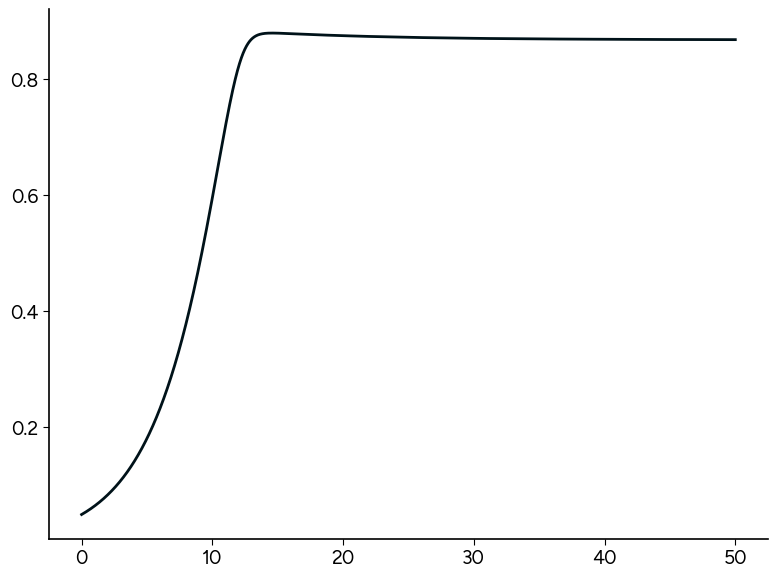

In [479]:
plt.plot(teval,soln_n.y[0],label="OD")


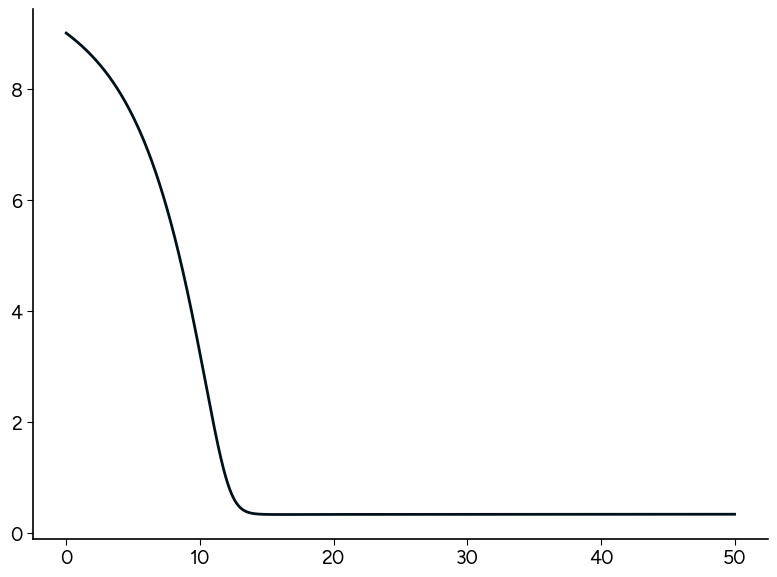

In [480]:
plt.plot(teval,soln_n.y[1],label="Resource")


In [481]:
@njit
def glv_rhs(t,y,g,alpha):
    dydot = y*(g - alpha*y)
    return dydot

In [482]:
def logistic_solution(t,g,alpha,x0):
    return x0 * g/alpha  / ((g/alpha - x0)*np.exp(-g*t) + x0)

theory_soln = lambda t,g,alpha: logistic_solution(t,g,alpha,initialn)

In [483]:
def glv_error(params):
    gvec,alphamatrix = params
    integrated_soln = integrate.solve_ivp(glv_rhs,[0,teval[-1]],[initialn],args=(gvec,np.array([[alphamatrix]])),t_eval=teval)
    return np.sum((integrated_soln.y[0] - soln_n.y[0])**2)

In [484]:
glv_lsq = optimize.minimize(glv_error,[0.1,0.1],method="Nelder-Mead",bounds=[(0,None),(0,None)])

g,alpha = glv_lsq.x

print(g,alpha)

0.361026362437008 0.41025512637162387


In [485]:
soln_glv_bootstrap = integrate.solve_ivp(glv_rhs,[0,teval[-1]],[initialn],args=(g,alpha),t_eval=teval)

In [486]:
fitvals,fitcorr  = optimize.curve_fit(theory_soln,teval,soln_n.y[0],p0=[1,1],bounds=([0,0],[np.inf,np.inf]))

g,alpha = fitvals
print(g,alpha)

soln_glv_theoryfit = integrate.solve_ivp(glv_rhs, (0,teval[-1]), [initialn], args=(g,np.array([[alpha]])), t_eval=teval)

0.36112141323787733 0.4103602718595859


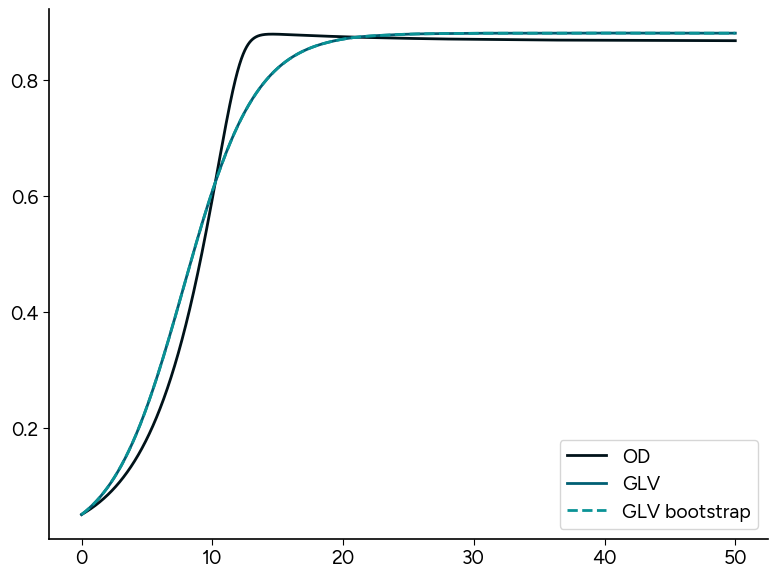

In [487]:
plt.plot(teval,soln_n.y[0],label="OD")
plt.plot(teval,soln_glv_theoryfit.y[0],label="GLV")
plt.plot(teval,soln_glv_bootstrap.y[0],label="GLV bootstrap",ls="--")

plt.legend()

In [488]:
def testfn(c,n,mu,yiel,k,delta,s):
    return mu* k*n / (k+c)**2 / delta / yiel

In [494]:
plotnarray = np.linspace(0.01,1,1000)
plotcarrray = np.linspace(0.01,10,1000)

plotn,plotc = np.meshgrid(plotnarray,plotcarrray)

plotfn = testfn(plotc,plotn,mu,yiel,k,delta,s)

In [495]:
oneLocs = np.where(plotfn == 1)

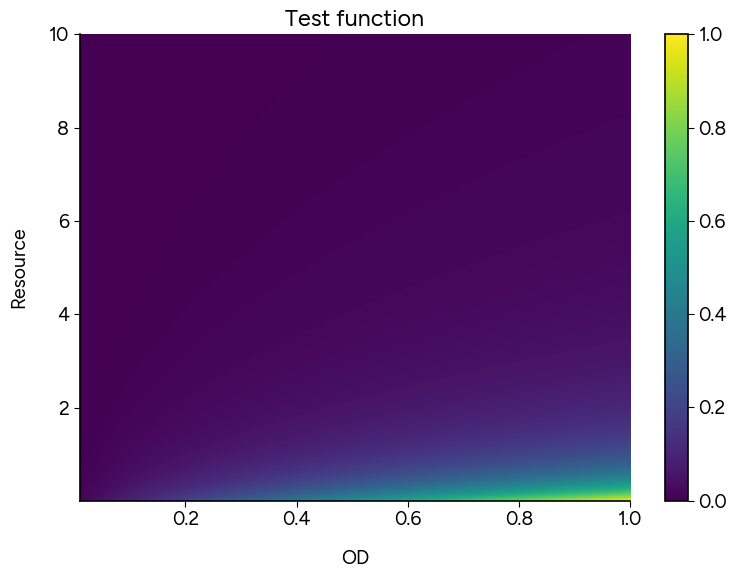

In [499]:
plt.figure()
plt.imshow((plotfn),extent=(0.01,1,0.01,10),origin="lower",aspect="auto",cmap="viridis")
plt.scatter(plotnarray[oneLocs[0]],plotcarrray[oneLocs[1]],c="red")
# plt.yscale("log")
plt.colorbar()
plt.xlabel("OD")
plt.ylabel("Resource")
plt.title("Test function")
plt.show()

In [500]:
def glv_approx_params(c,mu,k,yiel,delta,s):
    sij = mu*k / (k+c)**2
    fi = delta*(s-c) 
    df_de = -delta
    eC = mu*c / (k+c) / yiel
    de_dE = mu*k / (k+c)**2 / yiel

    mij = de_dE / eC * fi - df_de
    gcalc = fi / mij / sij
    alphacalc = eC / sij/mij
    return gcalc,alphacalc

In [521]:
def third_order_approx(c,mu,k,yiel,delta,s):
    sij = mu*k / (k+c)**2
    fi = delta*(s-c) 
    df_de = -delta
    eC = mu*c / (k+c) / yiel
    de_dE = mu*k / (k+c)**2 / yiel

    minv = 1/delta * (1+ mu*k*f/eC / delta / yiel / (k+c)**2)
    gcalc = fi *minv / sij
    alphacalc = eC / sij * minv
    return gcalc,alphacalc

In [501]:
def qssC(n,mu,k,yiel,delta,s):
    bterm = (-s + k + n*mu/delta/yiel)
    aterm = 1
    cterm = -s * k
    return (-bterm + np.sqrt(bterm**2 - 4*aterm*cterm))/(2*aterm)

In [502]:
qssCvsT = np.array([qssC(n,mu,k,yiel,delta,s) for n in soln_n.y[0]])

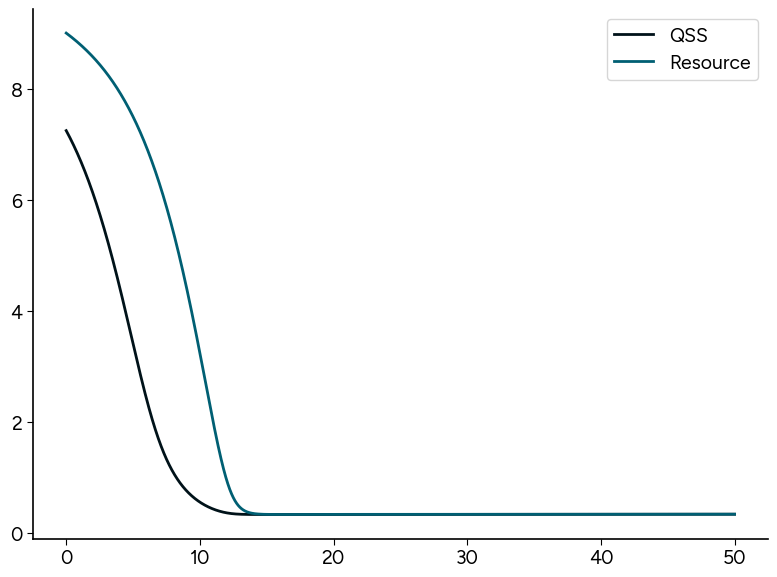

In [503]:
plt.plot(teval,qssCvsT,label="QSS")
plt.plot(teval,soln_n.y[1],label="Resource")

plt.legend()

In [527]:
paramsOfApprox = glv_approx_params(qssCvsT[-1],mu,k,yiel,delta,s)
paramsApproxTimeTraj = np.array([glv_approx_params(c,mu,k,yiel,delta,s) for c in qssCvsT])

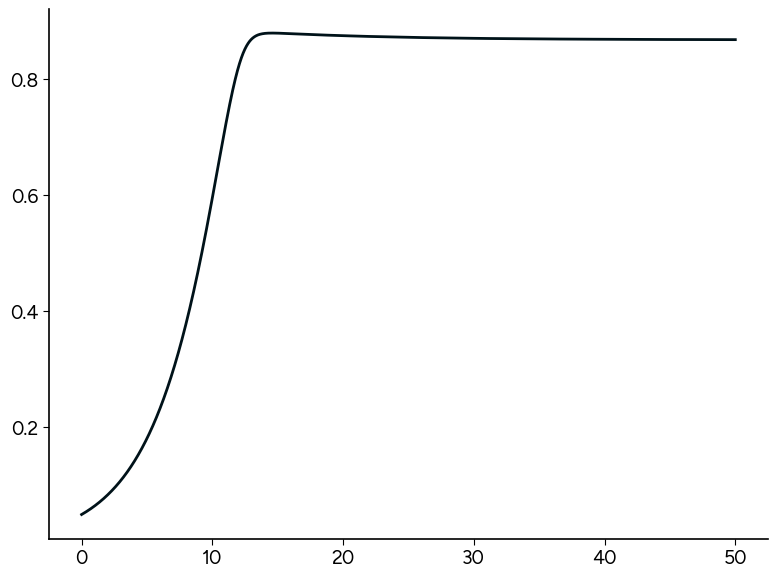

In [528]:
plt.plot(teval,paramsApproxTimeTraj[:,0]/paramsApproxTimeTraj[:,1],label="QSS C")

In [529]:
paramsOfApprox[1]/paramsOfApprox[0]

1.1533956174491402

In [530]:
fitvals[1]/fitvals[0]

1.1363498724161063

In [531]:
print(paramsOfApprox)
print(fitvals)

(1.8773827598259172, 2.165365047457785)
[0.36112141 0.41036027]


In [532]:
soln_n.y[0][-1]

0.8670052017464813

In [533]:
qssC(soln_n.y[0][-1],mu,k,yiel,delta,s)

0.33316827504598123

In [534]:
soln_n.y[1][-1]

0.33331696918132686

In [535]:
soln_n.y[0][-1]

0.8670052017464813

In [536]:
mu,k,yiel,delta,s

(0.4, 1, 0.1, 0.1, 9)

In [537]:
@njit
def timeDepGLV(t,y,g,alpha):
    return y*(g - alpha*y)

In [538]:
gTime = paramsApproxTimeTraj[:,0]
alphaTime = paramsApproxTimeTraj[:,1]

In [539]:
@njit
def rk4Integrator(func,t,y,dt,args):
    k1 = dt*func(t,y,*args)
    k2 = dt*func(t+dt/2,y+k1/2,*args)
    k3 = dt*func(t+dt/2,y+k2/2,*args)
    k4 = dt*func(t+dt,y+k3,*args)
    return y + (k1 + 2*k2 + 2*k3 + k4)/6

In [540]:
timeDepN = np.zeros_like(soln_n.y[0])
timeDepN[0] = initialn
dt = teval[1] - teval[0]

for i in range(1,len(teval)):
    timeDepN[i] = rk4Integrator(timeDepGLV,teval[i-1],timeDepN[i-1],dt,(gTime[i-1],alphaTime[i-1]))
    

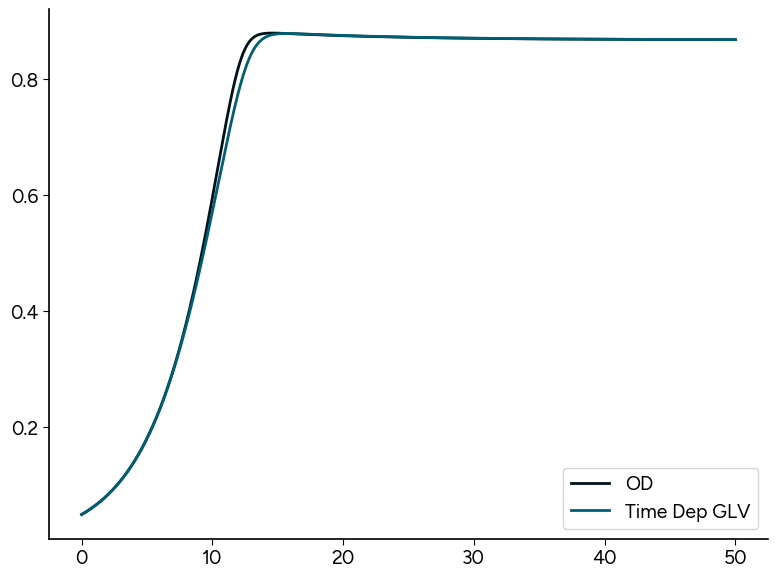

In [541]:
plt.plot(teval,soln_n.y[0],label="OD")
plt.plot(teval,timeDepN,label="Time Dep GLV")

plt.legend()

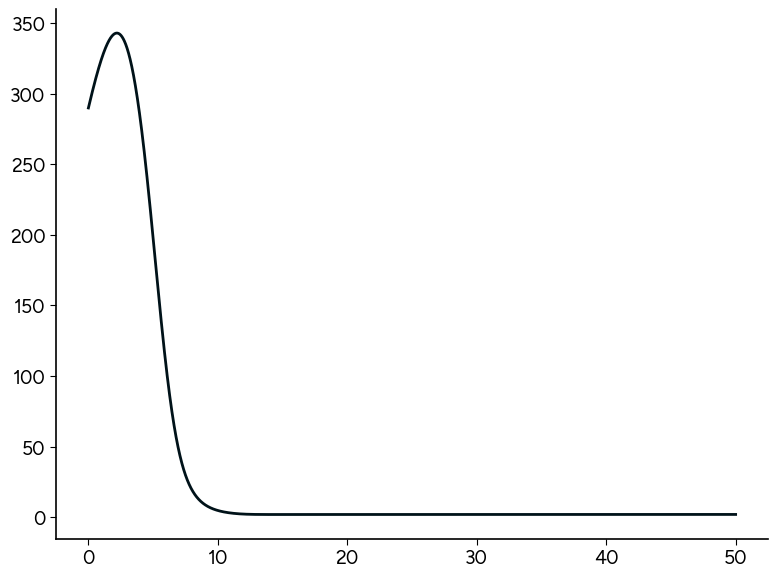

In [519]:
plt.plot(teval,gTime)


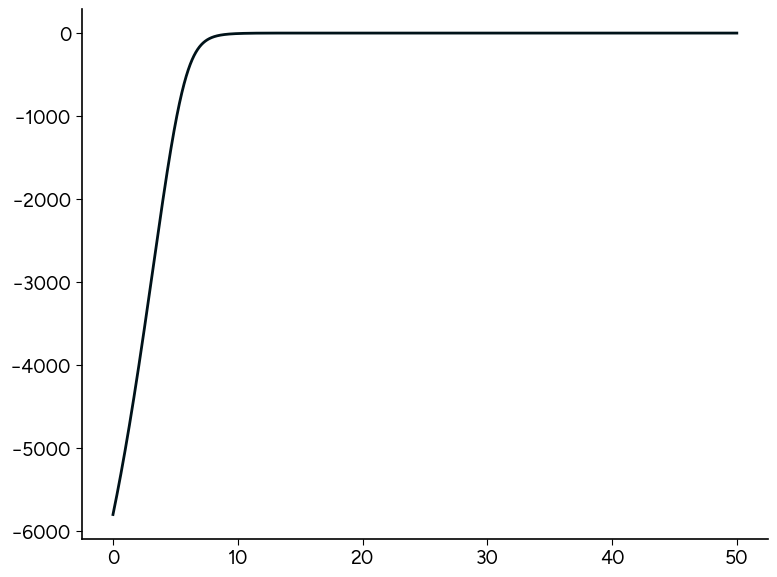

In [520]:
plt.plot(teval,-alphaTime)